# ACE estimations from real observational data

This notebook serves as a demonstration of the `CausalEffectEstimation` module for estimating causal effects on both generated and real datasets.

| | | |
|-|-|-|
|[ ![Creative Commons License](images/cc4.png)](http://creativecommons.org/licenses/by-nc/4.0/) |[ ![aGrUM](images/logoAgrum.png)](https://agrum.org) |[ ![interactive online version](images/atbinder.svg)](https://agrum.gitlab.io/extra/agrum_at_binder.html)

In [1]:
import pyagrum as gum
import pyagrum.lib.discretizer as disc
import pyagrum.lib.notebook as gnb
import pyagrum.lib.explain as gexpl

import pyagrum.causal as csl
import pyagrum.causal.notebook as cslnb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In this example, we show how to estimate the ACE (Average Causal Effect) using real data that does not adhere to RCT conditions. 

## Dataset

The dataset under consideration is the [Census Adult Income dataset](https://www.kaggle.com/datasets/uciml/adult-census-income).
The objective of this analysis is to determine whether possessing a graduate degree increases the likelihood of earning an income exceeding $50,000 per year.

In [2]:
df = pd.read_pickle("./res/df_causal_discovery.p")
df = df.rename(columns={"hours-per-week": "hoursPerWeek"})
df.describe()

,age,hoursPerWeek,hasGraduateDegree,inRelationship,isWhite,isFemale,greaterThan50k
count,29170.000000,29170.000000,29170.000000,29170.000000,29170.000000,29170.000000,29170.000000
mean,38.655674,40.447755,0.052348,0.406616,0.878334,0.331916,0.245835
std,13.722408,12.417203,0.222732,0.491211,0.326905,0.470909,0.430588
min,17.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,40.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,37.000000,40.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,48.000000,45.000000,0.000000,1.000000,1.000000,1.000000,0.000000
max,90.000000,99.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Setup

We begin by focusing exclusively on the age covariate to inform our estimations. We hypothesize that age is a causal factor influencing both the hasGraduateDegree variable and the greaterThan50k outcome.

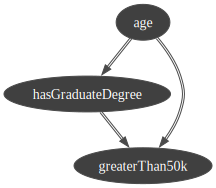

In [3]:
discretizer = disc.Discretizer(defaultDiscretizationMethod="NoDiscretization", defaultNumberOfBins=None)
template = discretizer.discretizedTemplate(df[["age", "hasGraduateDegree", "greaterThan50k"]])
template.addArcs([("age","hasGraduateDegree"), ("age", "greaterThan50k"), ("hasGraduateDegree", "greaterThan50k")])

causal_model = csl.CausalModel(template)

cslnb.showCausalModel(causal_model, size="50")

In [4]:
T = "hasGraduateDegree"
Y = "greaterThan50k"
X = "age"

In [5]:
cee = csl.CausalEffectEstimation(df, causal_model)

## Causal Identification

In [6]:
cee.identifyAdjustmentSet(intervention=T, outcome=Y)

Backdoor adjustment found. 

Supported estimators include:
- CausalModelEstimator
- SLearner
- TLearner
- XLearner
- PStratification
- IPW


'Backdoor'

## Causal Estimation

In [7]:
cee.fitCausalBNEstimator()
tau_hat = cee.estimateCausalEffect()

print(f"ACE = {tau_hat}")

ACE = 0.2332334047559898


In [8]:
cee.fitSLearner()
tau_hat = cee.estimateCausalEffect()

print(f"ACE = {tau_hat}")

ACE = 0.29760513570330305


In [9]:
cee.fitIPW()
tau_hat = cee.estimateCausalEffect()

print(f"ACE = {tau_hat}")

ACE = 0.29038491617382467


## Incorporating covariates and Unknown Adjustment

Let's examine whether incorporating all available covariates influences the estimation of the ACE. We will employ structure learning techniques to determine the DAG that the algorithm identifies from the data.

In [10]:
discretizer = disc.Discretizer(defaultNumberOfBins=5, defaultDiscretizationMethod="uniform")
template = discretizer.discretizedTemplate(df)

In [11]:
structure_learner = gum.BNLearner(df, template)
# we help the learning algorithm by giving it some causal constraints
structure_learner.setSliceOrder([["isWhite","isFemale"],
                                 ["age"],
                                 ["hasGraduateDegree","inRelationship","hoursPerWeek"]])
structure_learner.addNoParentNode("isWhite")
structure_learner.addNoParentNode("isFemale")
structure_learner.useNMLCorrection()
structure_learner.useSmoothingPrior(1e-6)

learned_bn = structure_learner.learnBN()

causal_model = csl.CausalModel(learned_bn)

In [12]:
gnb.sideBySide(gexpl.getInformation(learned_bn, size="50"))

In [13]:
cee = csl.CausalEffectEstimation(df, causal_model)

In [14]:
cee.identifyAdjustmentSet(intervention=T, outcome=Y)

Backdoor adjustment found. 

Supported estimators include:
- CausalModelEstimator
- SLearner
- TLearner
- XLearner
- PStratification
- IPW


'Backdoor'

In this scenario, no adjustment set is available for causal inference:

- This is not a randomized controlled trial (RCT) due to the presence of a backdoor path from `hasGraduateDegree` to `greaterThan50k`, which traverses through `age` and `inRelationship`.
- The backdoor criterion is not met, as every node is a descendant of the intervention variable `hasGraduateDegree`.
- The (Generalized) Frontdoor criterion is not applicable due to the absence of mediator variables.
- There are no (Generalized) Instrumental Variables, as `hasGraduateDegree` lacks any ancestors in the causal graph.

Consequently, the causal effect can only be estimated using the CausalBNEstimator, provided that the causal effect of the intervention on the outcome is identifiable through do-calculus. 

In [15]:
cee.fitCausalBNEstimator()
tau_hat = cee.estimateCausalEffect()

print(f"ACE = {tau_hat}")

ACE = 0.24151595674049398


We observe a stronger Causal Effect within the previously defined causal structure.

## User specified adjustment

Alternatively, it is possible to manually specify an adjustment set. However, it is important to note that this approach does not guarantee an asymptotically unbiased estimator.

In [16]:
cee.useBackdoorAdjustment(T, Y, {"age", "inRelationship"})

In [17]:
cee.fitSLearner()
tau_hat = cee.estimateCausalEffect()

print(f"ACE = {tau_hat}")

ACE = 0.28604936465903774


In [18]:
cee.fitTLearner()
tau_hat = cee.estimateCausalEffect()

print(f"ACE = {tau_hat}")

ACE = 0.2749304594008818


In [19]:
cee.fitIPW()
tau_hat = cee.estimateCausalEffect()

print(f"ACE = {tau_hat}")

ACE = 0.27130820286993246


We obtain more consistent results when specifying the backdoor adjustment using a selected subset of covariates.

## CACE estimations

To estimate the Conditional Average Causal Effect (CACE) using `CausalEffectEstimation`, pandas query strings can be utilized to specify the relevant conditions. Additionally, the Individual Causal Effect (ICE) can be estimated by providing a `pandas.DataFrame` containing the features of the individual units.

In [20]:
cee.fitTLearner()
tau_hat0 = cee.estimateCausalEffect(conditional="inRelationship == 0")
tau_hat1 = cee.estimateCausalEffect(conditional="inRelationship == 1")

print(f"CACE (inRelationship == 0) = {tau_hat0}")
print(f"CACE (inRelationship == 1) = {tau_hat1}")

CACE (inRelationship == 0) = 0.22769492525674218
CACE (inRelationship == 1) = 0.3438622409117925


In [21]:
cee.fitTLearner()
tau_hat0 = cee.estimateCausalEffect(conditional="isFemale == 0")
tau_hat1 = cee.estimateCausalEffect(conditional="isFemale == 1")

print(f"CACE (isFemale == 0) = {tau_hat0}")
print(f"CACE (isFemale == 1) = {tau_hat1}")

CACE (isFemale == 0) = 0.29838950581221924
CACE (isFemale == 1) = 0.22771192020813805


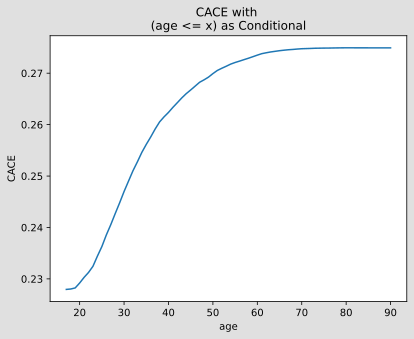

In [22]:
cee.fitTLearner()
changes = sorted(df["age"].unique())
booking = list()

for i in changes:
    tau_hat = cee.estimateCausalEffect(conditional=f"age <= {i}")
    booking.append(tau_hat)

plt.plot(changes, booking)
plt.title("CACE with \n(age <= x) as Conditional")
plt.xlabel("age")
plt.ylabel("CACE")
plt.show()

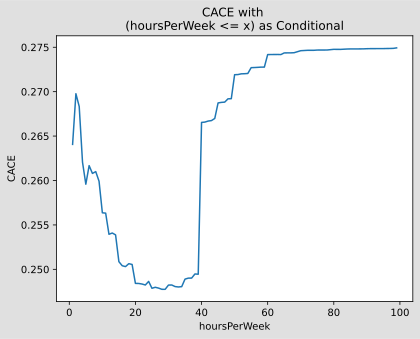

In [23]:
cee.fitTLearner()
changes = sorted(df["hoursPerWeek"].unique())
booking = list()

for i in changes:
    tau_hat = cee.estimateCausalEffect(conditional=f"hoursPerWeek <= {i}")
    booking.append(tau_hat)

plt.plot(changes, booking)
plt.title("CACE with \n(hoursPerWeek <= x) as Conditional")
plt.xlabel("hoursPerWeek")
plt.ylabel("CACE")
plt.show()